In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("colorblind")
from matplotlib.gridspec import GridSpec
from adjustText import adjust_text
import pickle

In [2]:
selected_brands = pd.read_csv('selected_brands.csv')['brands']
cbg_edu = pd.read_csv('cbg_edu.csv', dtype = {'cbg': str})
cbg_unpack = pd.read_csv('cbg_unpack.csv', dtype = {'visitor_home_cbgs': str})
yelp_labelled = pd.read_csv("yelp_labelled.csv")

# get poi_visitor_edu

- Every row has a unique pair of visitor_home_cbg and poi.
- Linked with cbg edu for the home_cbg.
- only include selected brands

In [6]:
poi_visitor_edu  = cbg_unpack[cbg_unpack['brands'].isin(selected_brands)]
poi_visitor_edu  = pd.merge(poi_visitor_edu, cbg_edu, left_on = 'visitor_home_cbgs', right_on = 'cbg')
poi_visitor_edu  = poi_visitor_edu.drop(columns = ['visitor_home_cbgs'])
poi_visitor_edu = poi_visitor_edu.dropna(subset = ["bachelor_or_higher"])

In [7]:
poi_visitor_edu

,placekey,brands,cbg_visitor_count,cbg,bachelor_or_higher,years_edu_weighted
0,zzw-23k@627-s8r-dgk,CVS,4,120330011031,0.610662,15.541195
1,zzw-223@627-wbv-k4v,Ripley's Entertainment Inc,4,120330011031,0.610662,15.541195
2,zzw-23k@627-s8r-dgk,CVS,4,421010030012,0.468697,13.546531
3,zzw-23k@627-s8r-dgk,CVS,4,360810717013,0.539204,14.647768
4,222-222@627-s7t-sh5,Mobil,8,360810717013,0.539204,14.647768
...,...,...,...,...,...,...
1199502,zzw-222@63q-kw3-yqf,Wendy's,4,391650307001,0.315700,13.908987
1199503,224-222@627-s8n-52k,Fine Fare Supermarkets,4,240430004003,0.058442,12.125541
1199504,zzy-223@629-n9r-r49,Eastern Mountain Sports,5,260290008001,0.332275,14.231746
1199505,zzw-222@63q-5gb-jvz,Byrne Dairy,4,060710091071,0.230114,13.729302


In [8]:
# get distribution of all visits
whole_array = (poi_visitor_edu.loc[poi_visitor_edu.index.repeat(poi_visitor_edu['cbg_visitor_count'])])['bachelor_or_higher']

In [9]:
whole_array

0          0.610662
0          0.610662
0          0.610662
0          0.610662
1          0.610662
             ...   
1199505    0.230114
1199506    0.335570
1199506    0.335570
1199506    0.335570
1199506    0.335570
Name: bachelor_or_higher, Length: 6074662, dtype: float64

In [10]:
whole_array.value_counts()

0.000000    23191
0.500000     5130
0.333333     4867
0.410708     4735
0.125000     4129
            ...  
0.204244        4
0.683703        4
0.832790        4
0.696515        4
0.230114        4
Name: bachelor_or_higher, Length: 48502, dtype: int64

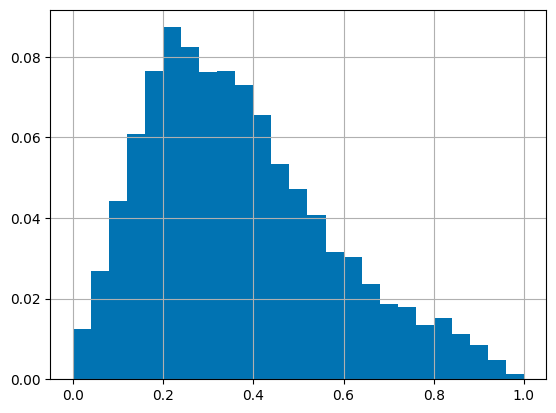

In [11]:
plt.figure()
whole_array.hist(weights = np.ones(len(whole_array)) / len(whole_array), bins = 25)
plt.show()

# for each brand get an array of visitors' home cbg median income


In [12]:
def get_extended_array(brand_name):
    '''input brand name, outout an array of visitors' home cbg median income
    '''
    
    brand = poi_visitor_edu[poi_visitor_edu['brands'] == brand_name]
    brand = brand[['bachelor_or_higher', 'cbg_visitor_count']]
    brand = brand.loc[brand.index.repeat(brand['cbg_visitor_count'])]
    brand = brand.reset_index(drop = True)
    array = np.array(brand['bachelor_or_higher'])
    return array

In [ ]:
brand_array_edu = pd.DataFrame({"brands": selected_brands})
array = brand_array_edu.apply(lambda row: get_extended_array(row['brands']), axis = 1)
brand_array_edu['array'] = array
brand_array_edu = brand_array_edu.set_index("brands")

In [19]:
# save raw data as pickle file
with open('brand_array_edu.pkl', 'wb') as fw:
    pickle.dump(brand_array_edu, fw)
fw.close()

In [ ]:
# open as pickle
with open('brand_array_edu.pkl', 'rb') as fr:
    brand_array_edu = pickle.load(fr)
fr.close()

# get median edu of brand visitors

In [10]:
brand_median_edu = brand_array_edu.apply(lambda row: np.median(row['array']), axis = 1)

In [11]:
sum(brand_median_edu == 0)

0

In [12]:
sum(whole_array == 0)

23191

In [13]:
brand_median_edu = pd.DataFrame(brand_median_edu)
brand_median_edu = brand_median_edu.rename({0: 'median'}, axis = 1)

In [14]:
brand_median_edu

,median
brands,
& Other Stories,0.374332
&pizza,0.618714
1-800-Flowers,0.446433
10 Spot/MadRag,0.233444
110 Grill,0.411598
...,...
lululemon athletica,0.480392
maurices,0.321798
rue21,0.262215


In [15]:
# brand_median_edu.to_csv('brand_median_edu.csv')

# plot brand ses edu vs yelp price level

In [17]:
sum(yelp_labelled['yelp_dollar'].isna())

148

In [18]:
sum(yelp_labelled['yelp_dollar'].notna())

776

In [19]:
edu_ses = pd.merge(yelp_labelled, brand_median_edu, on = 'brands')
edu_ses = edu_ses.dropna()

In [20]:
stats.pearsonr(edu_ses['median'], edu_ses['yelp_dollar'])

PearsonRResult(statistic=0.47429964436867983, pvalue=8.868894020358418e-45)

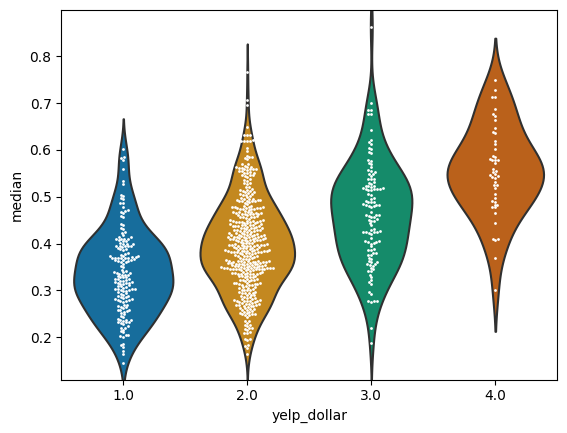

In [21]:
plt.figure()

ax = sns.violinplot(x="yelp_dollar", y="median", data=edu_ses, inner=None)
ax = sns.swarmplot(x="yelp_dollar", y="median", data=edu_ses,
                   color="white",  size=2, edgecolor="gray")

In [31]:
edu_ses.sort_values('median')

,brands,yelp_dollar,median
685,SHOP 'n SAVE Supermarkets,1.0,0.145161
608,Peachwave Yogurt,1.0,0.163812
333,Fox's Pizza Den,2.0,0.163842
324,Food Fair,1.0,0.170639
24,Aaron's,2.0,0.176656
...,...,...,...
494,Loro Piana,4.0,0.713602
180,Chanel,4.0,0.727794
414,Jacadi,4.0,0.750000
482,Learning Express Toys,2.0,0.766975


In [ ]:
stats.pearsonr(edu_ses['median'], edu_ses['yelp_dollar'])

PearsonRResult(statistic=0.47429964436867983, pvalue=8.868894020358418e-45)

In [25]:
callout = ['Lidl', 'Salsa Fresca Mexican Grill', 'Save-A-Lot', "Sears", "Green Cactus Grill", "Burger King",
           "Dollar Tree", "7-Eleven", "Taco Bell", "PriceRite", "Food Fair", "Forman Mills", "Victoria's Secret",
          "Zara", "Kmart", "Banana Republic", "Gap", "MAC Cosmetics", "Alexis Bittar", "Green's Natural Foods",
          "Kings Food Markets", "Whole Foods Market", "Johnson Fitness & Wellness", "UGG", "lululemon athletica",
          "Nike", "Timberland", "Camper", "Adidas", "Loro Piana", "Valentino", "Chanel", "Gucci",
          "Prada", "Canada Goose", "Tiffany & Co.", "Versace", "Fendi", "Peachwave Yogurt", "Marie Blachère", "Zales"]

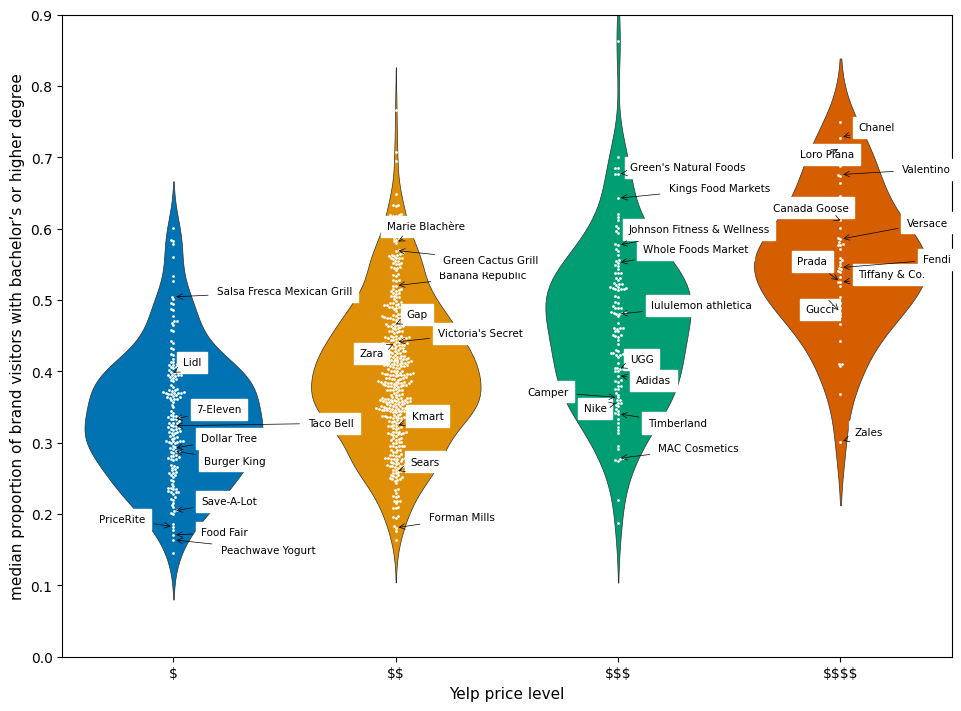

In [ ]:
fig, ax = plt.subplots(figsize=(9.5, 7), constrained_layout = True)
ax = sns.violinplot(x="yelp_dollar", y="median", data=edu_ses, inner=None, linewidth = 0.5,
                   saturation = 2)
ax = sns.swarmplot(x="yelp_dollar", y="median", data=edu_ses,
                   color="white",  size=2, edgecolor="gray")
ax.set_xlabel("Yelp price level", fontsize = 11)
ax.set_ylabel("median proportion of brand visitors with bachelor’s or higher degree", fontsize = 11)
ax.set_xticklabels(["\$", "\$\$", "\$\$\$", "\$\$\$\$"], fontsize = 10)
plt.yticks(np.arange(0, 1, 0.1))
ax.yaxis.set_tick_params(labelsize = 10)

TEXTS = []
for i in range(len(edu_ses)):
    if edu_ses['brands'].iloc[i] in callout:
        x = edu_ses["yelp_dollar"].iloc[i] - 1
        y = edu_ses["median"].iloc[i]
        text = edu_ses['brands'].iloc[i]
        TEXTS.append(ax.text(x, y, text, fontsize = 7.5, backgroundcolor = 'white'))
        
adjust_text(
    TEXTS, 
    expand_points = (2, 2),
    expand_text = (2, 1.5),
    expand_objects = (2, 2),
    force_points = 0.2, 
    force_text = 0.3,
    force_objects = 0.2,
    arrowprops = dict(
        arrowstyle = "->",  
        linewidth = 0.5
    ),
    ax=fig.axes[0]
)

for i in range(len(TEXTS)):
    if TEXTS[i].get_text() == 'Gucci':
       #TEXTS[i].set_x(3.12)
        TEXTS[i].set_y(0.48)
        break
# plt.savefig('Appendix/FigureE2.png', dpi = 300)

# plot

In [27]:
# get distribution of all cbgs
all_cbg = poi_visitor_edu[['cbg', 'bachelor_or_higher']].drop_duplicates().reset_index(drop = True)
all_cbg = all_cbg['bachelor_or_higher']

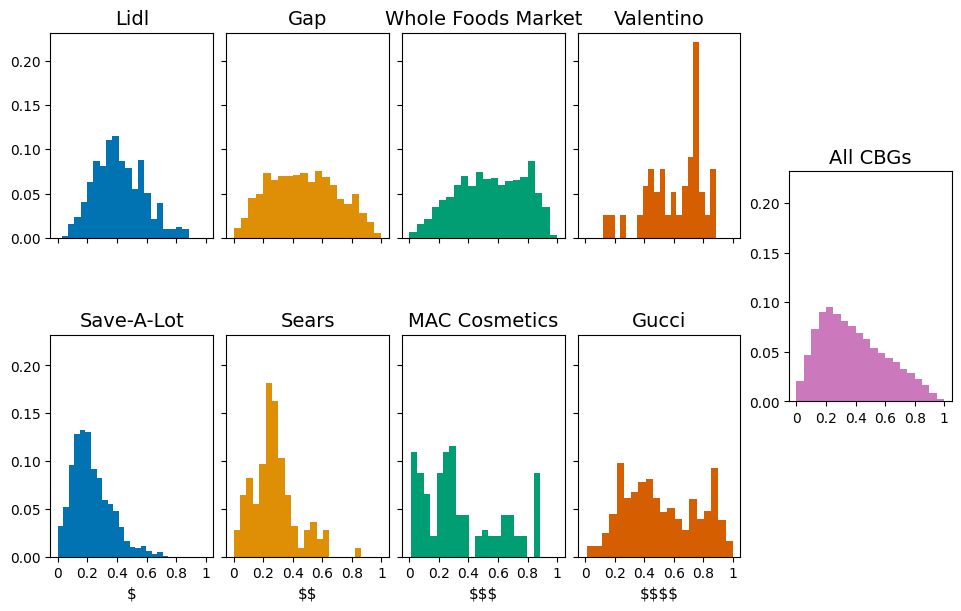

<Figure size 640x480 with 0 Axes>

In [28]:
# plot

pbrands = ["Lidl", "Gap", "Whole Foods Market", "Valentino",
           'Save-A-Lot', "Sears", "MAC Cosmetics", "Gucci"]

## create the gridspec
fig = plt.figure(figsize=(9.5, 6), constrained_layout = True)
gs = GridSpec(4, 5, figure = fig)
ax_lst = []
for i in range(9):
    if i < 4:
        if i == 0:
            ax_lst.append(fig.add_subplot(gs[:2, i]))
        else:
            ax_lst.append(fig.add_subplot(gs[:2, i], sharex=ax_lst[0], sharey=ax_lst[0]))
    elif i < 8:
        ax_lst.append(fig.add_subplot(gs[2:4, i - 4], sharex=ax_lst[0], sharey=ax_lst[0]))
    else:
        ax_lst.append(fig.add_subplot(gs[1:3, 4], sharex=ax_lst[0], sharey=ax_lst[0]))


## set the parameters to be filled 
binwidth = 10000
titles = ["Lidl", "Gap", "Whole Foods Market", "Valentino",
           'Save-A-Lot', "Sears", "MAC Cosmetics", "Gucci", 'All CBGs']
xlabels = [None]*4 + ["\$", "\$\$", "\$\$\$", "\$\$\$\$"] + [None]
bincolors = sns.color_palette()[0:4] + sns.color_palette()[0:4] + [sns.color_palette()[4]]
labelbottoms = [False]*4 + [True]*5
labellefts = [True] + [False]*3 + [True] + [False]*3 + [True]

for i in range(len(ax_lst)):
    if i < 8:
        array = brand_array_edu.loc[pbrands[i],'array']
    else:
        array = all_cbg
        
    ax_lst[i].hist(array, 
                   weights = np.ones(len(array)) / len(array),
                   color = bincolors[i], 
                   bins = 20)
        
    ax_lst[i].set_title(titles[i], fontsize = 14) 
    ax_lst[i].set_xlabel(xlabels[i], fontsize = 11)
    ax_lst[i].xaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax_lst[i].set_xticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1"])
    ax_lst[i].xaxis.set_tick_params(labelsize = 10)
    ax_lst[i].yaxis.set_tick_params(labelsize = 10)
    ax_lst[i].tick_params(labelbottom = labelbottoms[i], labelleft = labellefts[i])

plt.show()
# plt.savefig('Appendix/FigureE3.png', dpi = 300)
        